# Homework 03: Learning Curves and Training Workflow

**Points:** 85

In this assignment, you will learn how to design, train, and evaluate neural networks by systematically exploring key design choices. Your focus will be on developing an effective **training workflow** — using learning curves and validation metrics to guide your decisions.

We'll use the **Forest Cover Type (Covertype) dataset,** which has ~581k tabular records with 54 cartographic/topographic features (elevation, aspect, slope, soil and wilderness indicators) used to predict one of seven tree cover types in Colorado’s Roosevelt National Forest. It’s a large, mildly imbalanced multi-class benchmark commonly used to compare classical ML and deep learning on tabular data.

We will start with a **baseline model** (two hidden layers of sizes 64 and 32), and gradually introduce and tune different hyperparameters. Each of the first five problems considers  different hyperparameter choices, and the last problem is your chance to use what you have learned to design your best model:

1. **Activation function** – Compare ReLU, sigmoid, and tanh to see which provides the best accuracy.
2. **Learning rate** – Explore a range of learning rates and identify which balances convergence speed and stability.
3. **Dropout** – Investigate how different dropout rates reduce overfitting and where they are most effective.
4. **L2 regularization** – Experiment with weight penalties to encourage simpler models and avoid memorization.
5. **Dropout + L2** – Combine both regularization techniques and study their interaction.
6. **Best model design** – Use all your insights to build and train your strongest model, with the option to try **learning rate scheduling** for further improvement.

In this homework, you will use **early stopping** to select the "best" model at the epoch of **minimum validation loss**, and you will report the **validation accuracy** of that selected model as the primary measure of performance. Test accuracy is reported for reference but is not used for model selection.

> **Note:** Throughout this homework, best always refers to the model selected by early stopping at the epoch of minimum validation loss. Do not report metrics from the final training epoch unless explicitly instructed.

By the end of this homework, you will not only understand how different hyperparameters affect training and generalization, but also gain hands-on practice in building a disciplined workflow for model development.

There are 10 graded problems, worth 8 points each, with 5 points for free if you complete the homework.

In [1]:
# Useful imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import os

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay


from tensorflow.keras.datasets import fashion_mnist

# utility code

random_seed = 42

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages


In [2]:
# Utility function to plot learning curves and keep track of all results

# Call `print_results()` to see listing of all results logged so far


def plot_learning_curves(hist, title, verbose=True):

    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,min_val_epoch + 1)

results = {}

**The plotting function will record the validation accuracy for each experiment, using the plot title as key. The next function will print these out (see the last cell in the notebook).**


In order to see all results, you must give a different plot title to each experiment.

In [3]:
def print_results():
    for title, (acc, ep) in sorted(results.items(),
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}")

### Wrapper to train, display results, and run test set

We assume multi-class classification, and allow setting various parameters for training.

In [4]:
# Uses globals X_train,y_train,X_val,y_val

def train_and_test(model,
                   epochs        = 500,                   # Just needs to be bigger than early stop point
                   lr_schedule   = 0.001,                 # Adam default / 10 seems to work well for this dataset
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 64,                     # experiments confirmed this was optimal with other parameters at default
                   use_early_stopping = True,
                   patience      = 10,
                   min_delta     = 0.0001,
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")


    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule)
    else:
        opt = optimizer

    #Compiling the model
    model.compile(optimizer=opt,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"]
                 )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,               # this will mean that the model which produced the smallest validation loss will be returned
        verbose=verbose
    )


    if use_early_stopping:
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()

    # Fit the model with early stopping
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),       # must use stratified validation set
                        callbacks=cbs,
                        verbose=verbose
                       )

    if use_early_stopping:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_acc   = history.history['val_accuracy'][best_epoch]

    # Plot training history
    plot_learning_curves(history, title=title)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")

    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    if return_history:
        return history

### Load the dataset and extract a stratified subset

This data set is rather large (581,012 samples) and unbalanced, but for the purposes of this homework, we use a much smaller set, and select samples so that it is balanced.

In [5]:
# complete cell: load, balance, split into X_train/y_train/x_val/y_val/X_test/y_test, and standardize
from collections import Counter
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1) load
x, y = fetch_covtype(return_X_y=True)  # y in {1..7}
print("full dataset shape:", x.shape)

# 2) build a perfectly balanced subset across 7 classes (no replacement)
classes, counts = np.unique(y, return_counts=True)
# min_count = counts.min()  # size of rarest class                         # You can modify this parameter to increase the size of the dataset, but above
min_count = 1000                                                           # counts.min() you'll produce an unbalanced set.


rng = np.random.default_rng(42)

idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = x[idx_bal]
y_sub = y[idx_bal] - 1  # relabel to {0..6} for keras
print("balanced subset shape:", X_sub.shape, "class counts:", dict(Counter(y_sub)))

# 3) stratified 60/20/20 split (train/val/test)
test_size = 0.20
val_size = 0.20  # of the whole dataset

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_sub, y_sub, test_size=test_size, random_state=random_seed, stratify=y_sub
)
val_size_rel = val_size / (1.0 - test_size)  # e.g., 0.20 / 0.80 = 0.25

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_size_rel, random_state=random_seed, stratify=y_trainval
)

# 4) standardize using train-only stats (float32 for tensorflow friendliness)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

# 5) quick sanity checks
def show_counts(name, y_arr):
    c = Counter(y_arr)
    total = sum(c.values())
    print(f"{name}: total={total}, per-class={dict(c)}")

print("shapes:", "X_train", X_train.shape, "X_val", X_val.shape, "X_test", X_test.shape)
show_counts("train", y_train)
show_counts("val  ", y_val)
show_counts("test ", y_test)

# you now have: X_train, y_train, X_val, y_val, X_test, y_test

# Looks like integer encoded multi-class, let's check and define the global n_classes

labels = np.unique(y_train)

n_classes = len(labels)

print("class labels:",labels)


full dataset shape: (581012, 54)
balanced subset shape: (7000, 54) class counts: {np.int32(2): 1000, np.int32(0): 1000, np.int32(4): 1000, np.int32(5): 1000, np.int32(1): 1000, np.int32(3): 1000, np.int32(6): 1000}
shapes: X_train (4200, 54) X_val (1400, 54) X_test (1400, 54)
train: total=4200, per-class={np.int32(2): 600, np.int32(1): 600, np.int32(0): 600, np.int32(3): 600, np.int32(5): 600, np.int32(4): 600, np.int32(6): 600}
val  : total=1400, per-class={np.int32(1): 200, np.int32(6): 200, np.int32(5): 200, np.int32(4): 200, np.int32(3): 200, np.int32(2): 200, np.int32(0): 200}
test : total=1400, per-class={np.int32(0): 200, np.int32(6): 200, np.int32(2): 200, np.int32(3): 200, np.int32(4): 200, np.int32(5): 200, np.int32(1): 200}
class labels: [0 1 2 3 4 5 6]


## Prelude: Defining a model builder

In order to facilitate our experimentation, we'll write a function which builds models according to specifications:

- How many layers
- How wide each layer is
- How much dropout in each layer
- How much L2 Regularization in each layer

This is a fairly standard practice in ML, since the structure of simple models is fairly predictable and can be specified by a few hyperparameters.

In [6]:
# This function will build a multi-class classifier with dropout and L2 regularization.
# You must specify the number of input features, the number of classes, and a list of layer hyperparameters
# in the form  [ ...., (width, activation function, L2 lambda, dropout rate), .... ]

# Note that when adding dropout, this appears as a separate layer, but it has no parameters to be trained.

def build_model(n_inputs,layer_list,n_classes):
    layers = [ Input(shape=(n_inputs,)) ]
    for (width,act,l2_lambda,dropout_rate) in layer_list:
        layers.append( Dense(width, activation=act, kernel_regularizer=regularizers.l2(l2_lambda)) )
        if dropout_rate > 0:
            layers.append( Dropout(dropout_rate) )
    layers.append( Dense(n_classes, activation='softmax') )
    return models.Sequential( layers )


**Example: To build the following model:**

In [7]:
model = models.Sequential(
   [
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0)),              # 0.0 means no regularization applied; no dropout, so no Dropout layer necessary
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
   ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

**We call `build_model` as shown here:**

In [8]:
build_model(X_train.shape[1], [ (64,'relu',0.0,0.0), (32,'relu',0.001,0.3)], n_classes).summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

-------------------



### Baseline Model Architecture

**Problems 1–5 will use the following baseline model structure,** implemented with the provided `build_model` function and trained using `train_and_test`:

```
input → 64 → 32 → output
```

* Two hidden layers of widths 64 and 32.
* Activation function, dropout rate, and L2 regularization term (λ) will vary as specified in each problem.
* **Early stopping** is always applied to select the model at the epoch of **minimum validation loss**.
* We will report the **validation accuracy** of the selected model as the primary metric.


### Problem One: Which Activation Function?

In this problem, you will train the **baseline neural network** and investigate which activation function produces the best performance. The model you create will be the one saved by **early stopping** — that is, the epoch where validation loss is minimized.

**Steps to follow:**

* Use the provided functions `train_and_test` and `build_model` to create a model named **`model_baseline`**.
* Train and evaluate this model using each of the following activation functions in the hidden layers:

  * `relu`
  * `sigmoid`
  * `tanh`
* Identify which activation function produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



=== Testing activation: relu ===

Activation: relu



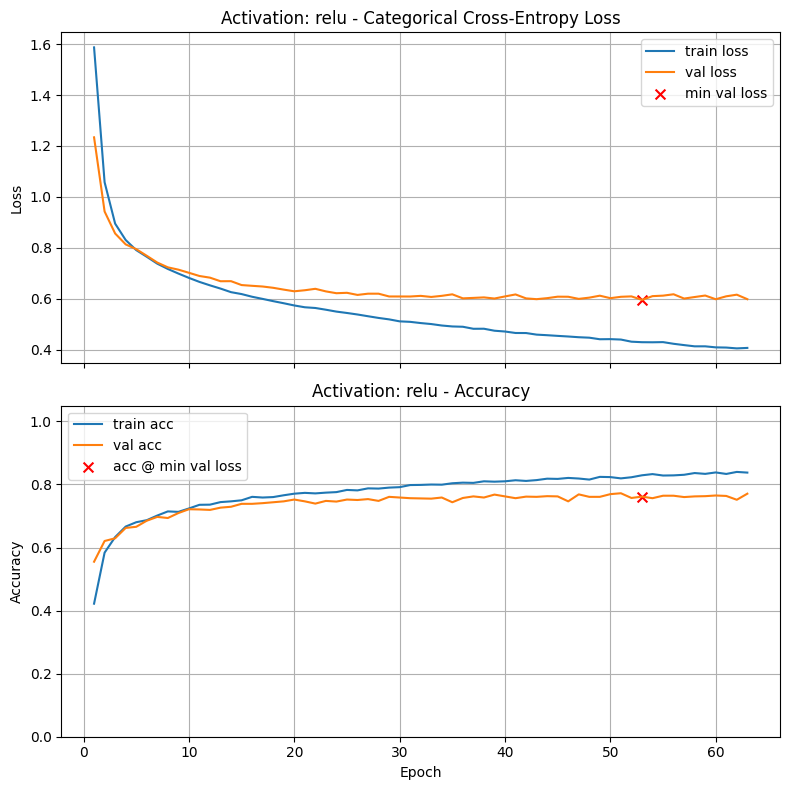

Final Training Loss:            0.4063
Final Training Accuracy:        0.8376
Final Validation Loss:          0.5978
Final Validation Accuracy:      0.7707
Minimum Validation Loss:        0.5951 (Epoch 53)
Validation Accuracy @ Min Loss: 0.7614

Test Loss: 0.6120
Test Accuracy: 0.7643

Validation-Test Gap (accuracy): 0.002857

Execution Time: 00:00:21

Best val accuracy for relu: 0.7614 (Epoch 52)

=== Testing activation: sigmoid ===

Activation: sigmoid



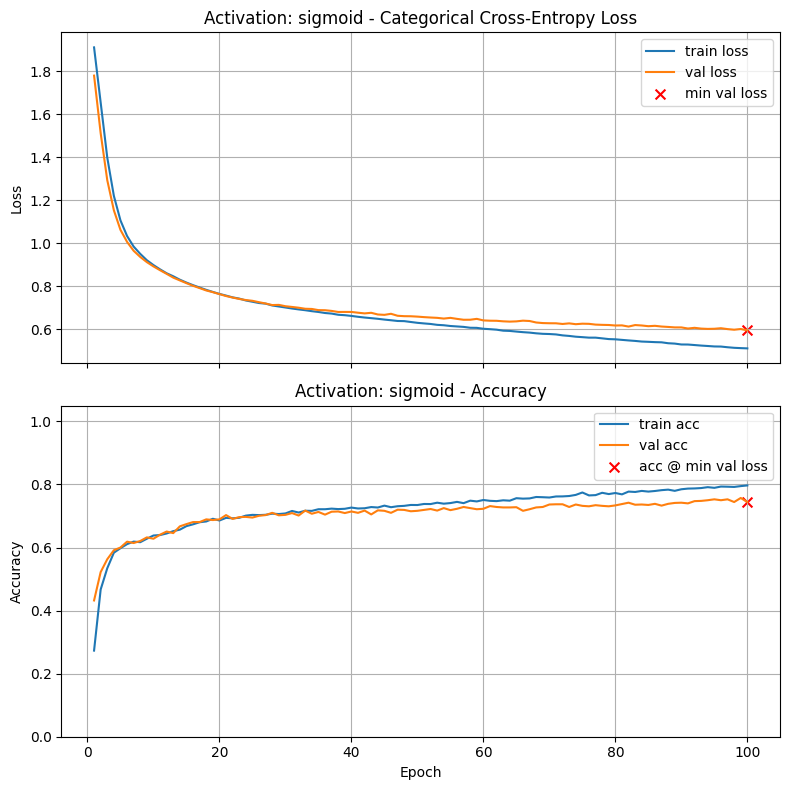

Final Training Loss:            0.5112
Final Training Accuracy:        0.7969
Final Validation Loss:          0.5952
Final Validation Accuracy:      0.7443
Minimum Validation Loss:        0.5952 (Epoch 100)
Validation Accuracy @ Min Loss: 0.7443

Test Loss: 0.6041
Test Accuracy: 0.7493

Validation-Test Gap (accuracy): 0.005000

Execution Time: 00:00:32

Best val accuracy for sigmoid: 0.7443 (Epoch 99)

=== Testing activation: tanh ===

Activation: tanh



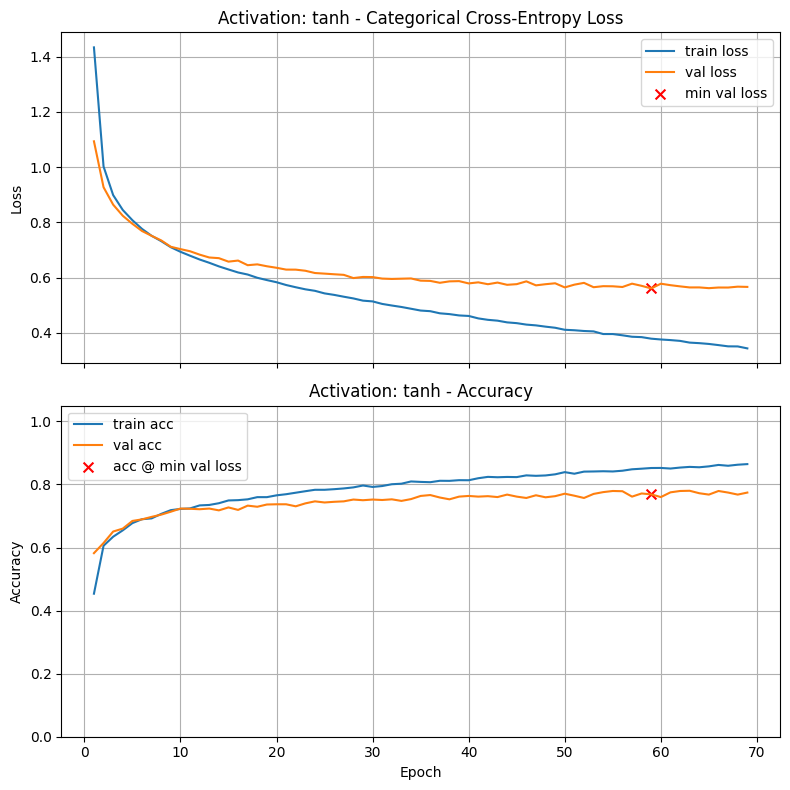

Final Training Loss:            0.3437
Final Training Accuracy:        0.8645
Final Validation Loss:          0.5663
Final Validation Accuracy:      0.7743
Minimum Validation Loss:        0.5608 (Epoch 59)
Validation Accuracy @ Min Loss: 0.7686

Test Loss: 0.5790
Test Accuracy: 0.7564

Validation-Test Gap (accuracy): 0.012143

Execution Time: 00:00:22

Best val accuracy for tanh: 0.7686 (Epoch 58)


In [9]:
# Your code here. Add as many cells as you need.
activations = ['relu', 'sigmoid', 'tanh']
results_act = {}

for act in activations:
    print(f"\n=== Testing activation: {act} ===")

    # Define baseline architecture: 64 → 32
    layer_list = [
        (64, act, 0.0, 0.0),    # No L2, no dropout
        (32, act, 0.0, 0.0)
    ]

    # Build and train model
    model_baseline = build_model(n_inputs=X_train.shape[1], layer_list=layer_list, n_classes=len(np.unique(y_train)))

    history = train_and_test(model_baseline,
                             epochs=100,
                             lr_schedule=0.001,
                             title=f"Activation: {act}",
                             verbose=0,
                             return_history=True)

    # Retrieve the best val accuracy from early stopping
    val_accs = history.history['val_accuracy']
    min_val_loss_epoch = np.argmin(history.history['val_loss'])
    best_val_acc = val_accs[min_val_loss_epoch]

    results_act[act] = (best_val_acc, min_val_loss_epoch)
    print(f"\nBest val accuracy for {act}: {best_val_acc:.4f} (Epoch {min_val_loss_epoch})")


In [10]:
results_act

{'relu': (0.7614285945892334, np.int64(52)),
 'sigmoid': (0.7442857027053833, np.int64(99)),
 'tanh': (0.7685714364051819, np.int64(58))}

In [12]:
sorted_results_act = dict(sorted(results_act.items(), key=lambda act: act[1], reverse=True))
sorted_results_act

{'tanh': (0.7685714364051819, np.int64(58)),
 'relu': (0.7614285945892334, np.int64(52)),
 'sigmoid': (0.7442857027053833, np.int64(99))}

### Graded Questions

In [14]:
# Set a1a to the activation function which provided the best validation accuracy at the epoch of minimum validation loss

a1a = 2             # Replace with integer 0 (relu), 1 (sigmoid), or 2 (tanh)

In [15]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a1a = {a1a}')


a1a = 2


In [16]:
# Set a1b to the validation accuracy found by this best activation function

a1b = sorted_results_act['tanh'][0]             # Replace 0.0 with your answer

In [17]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a1b = {a1b:.4f}')

a1b = 0.7686


### Problem Two: Finding the Right Learning Rate

In this problem, you will continue working with the **baseline model** and determine which learning rate produces the best performance. As before, the model you evaluate should be the one saved by **early stopping** — the epoch where validation loss is minimized.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function identified in Problem One**.

* Train and evaluate this model using each of the following learning rates:

  ```
      [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
  ```

* Identify which learning rate produces the **best validation accuracy** at the epoch of **minimum validation loss**, within a maximum of **500 epochs**.

* Answer the graded questions.


**Note: Smaller learning rates will generally take more epochs to reach the optimal point, so some of these will not engage early stopping, but run the full 500 epochs.**



=== Testing learning rate: 0.001 ===

LR = 0.001



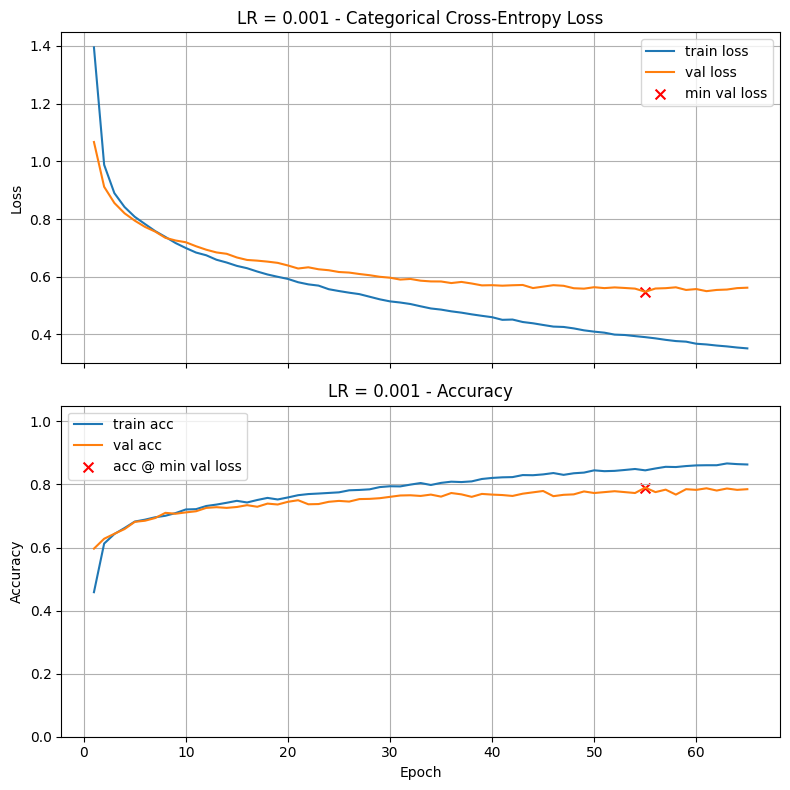

Final Training Loss:            0.3515
Final Training Accuracy:        0.8633
Final Validation Loss:          0.5619
Final Validation Accuracy:      0.7850
Minimum Validation Loss:        0.5478 (Epoch 55)
Validation Accuracy @ Min Loss: 0.7900

Test Loss: 0.5604
Test Accuracy: 0.7686

Validation-Test Gap (accuracy): 0.021429

Execution Time: 00:00:22
Best val accuracy for lr=0.001: 0.7900 (Epoch 54)

=== Testing learning rate: 0.0005 ===

LR = 0.0005



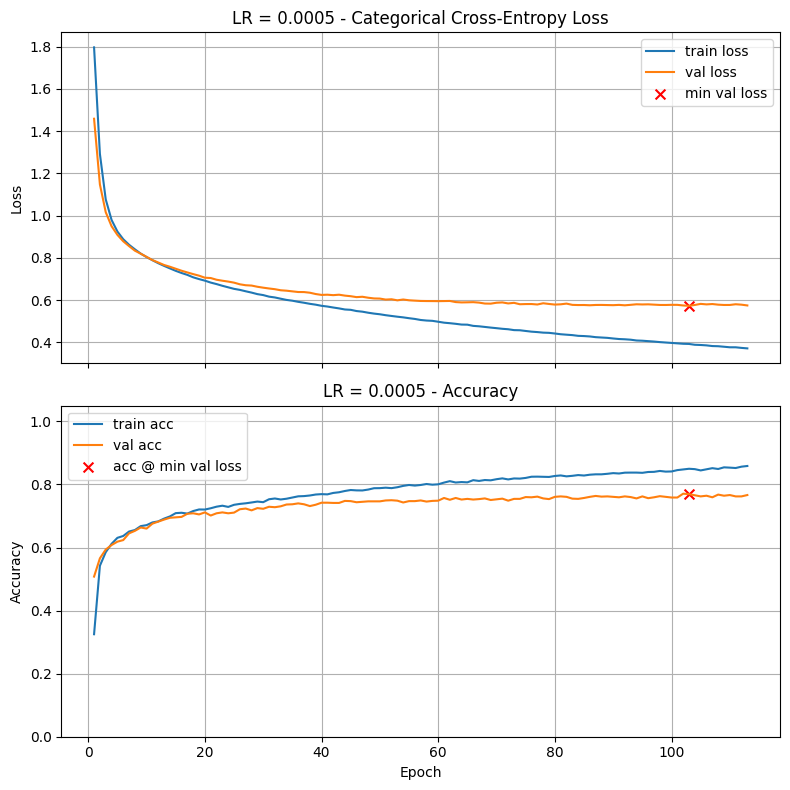

Final Training Loss:            0.3709
Final Training Accuracy:        0.8586
Final Validation Loss:          0.5743
Final Validation Accuracy:      0.7664
Minimum Validation Loss:        0.5724 (Epoch 103)
Validation Accuracy @ Min Loss: 0.7693

Test Loss: 0.5639
Test Accuracy: 0.7700

Validation-Test Gap (accuracy): 0.000714

Execution Time: 00:00:53
Best val accuracy for lr=0.0005: 0.7693 (Epoch 102)

=== Testing learning rate: 0.0001 ===

LR = 0.0001



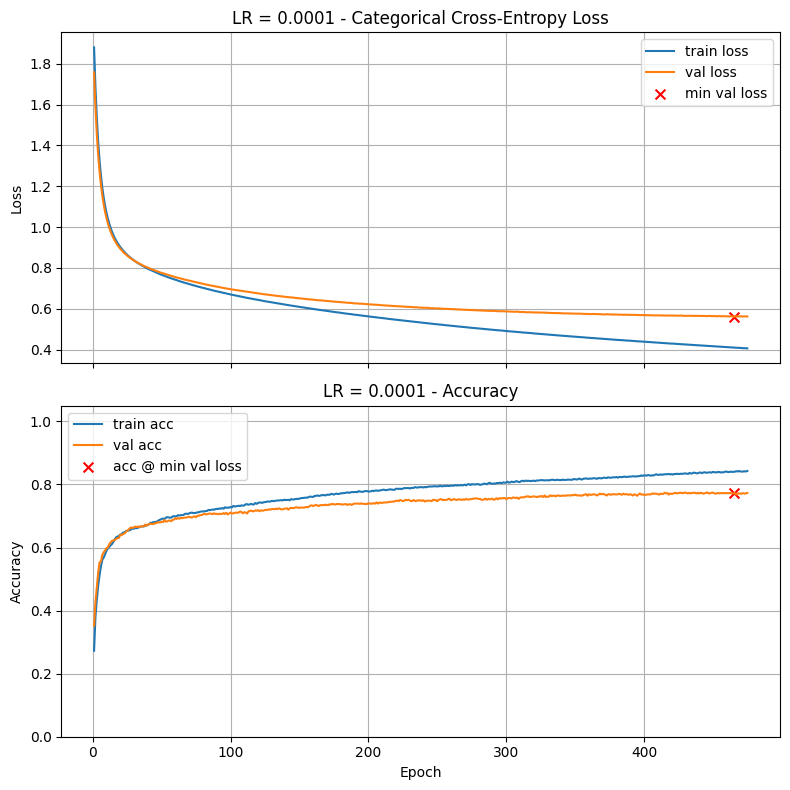

Final Training Loss:            0.4056
Final Training Accuracy:        0.8429
Final Validation Loss:          0.5619
Final Validation Accuracy:      0.7729
Minimum Validation Loss:        0.5613 (Epoch 465)
Validation Accuracy @ Min Loss: 0.7721

Test Loss: 0.5710
Test Accuracy: 0.7614

Validation-Test Gap (accuracy): 0.010714

Execution Time: 00:02:28
Best val accuracy for lr=0.0001: 0.7721 (Epoch 464)

=== Testing learning rate: 5e-05 ===

LR = 5e-05



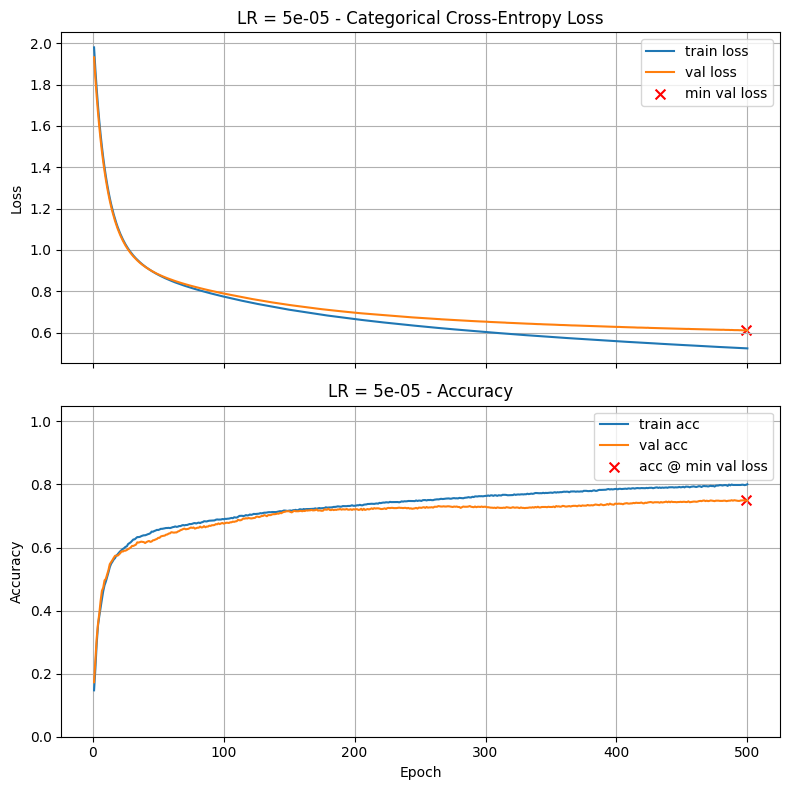

Final Training Loss:            0.5234
Final Training Accuracy:        0.8005
Final Validation Loss:          0.6106
Final Validation Accuracy:      0.7486
Minimum Validation Loss:        0.6106 (Epoch 499)
Validation Accuracy @ Min Loss: 0.7493

Test Loss: 0.6332
Test Accuracy: 0.7336

Validation-Test Gap (accuracy): 0.015714

Execution Time: 00:02:21
Best val accuracy for lr=5e-05: 0.7493 (Epoch 498)

=== Testing learning rate: 1e-05 ===

LR = 1e-05



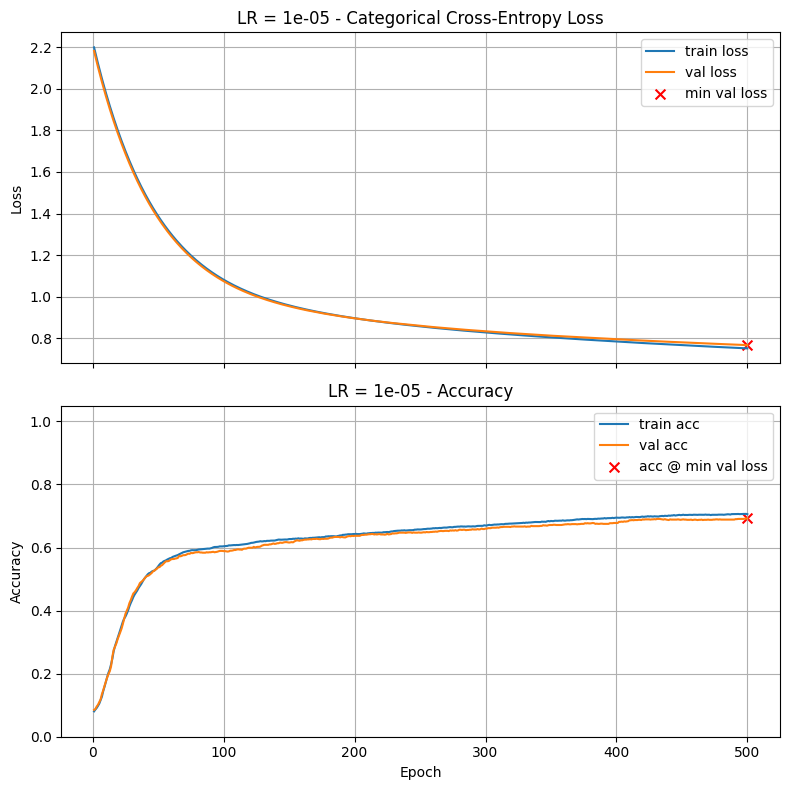

Final Training Loss:            0.7522
Final Training Accuracy:        0.7057
Final Validation Loss:          0.7679
Final Validation Accuracy:      0.6921
Minimum Validation Loss:        0.7679 (Epoch 500)
Validation Accuracy @ Min Loss: 0.6921

Test Loss: 0.7760
Test Accuracy: 0.6943

Validation-Test Gap (accuracy): 0.002143

Execution Time: 00:02:16
Best val accuracy for lr=1e-05: 0.6921 (Epoch 499)


In [18]:
# Your code here. Add as many cells as you need.
learning_rates = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
results_lr = {}

best_act = 'tanh'

for lr in learning_rates:
    print(f"\n=== Testing learning rate: {lr} ===")

    # Use same architecture
    layer_list = [
        (64, best_act, 0.0, 0.0),
        (32, best_act, 0.0, 0.0)
    ]

    # Build model
    model_baseline = build_model(n_inputs=X_train.shape[1], layer_list=layer_list, n_classes=len(np.unique(y_train)))

    # Train model
    history = train_and_test(model_baseline,
                             epochs=500,
                             lr_schedule=lr,
                             batch_size=64,
                             title=f"LR = {lr}",
                             verbose=0,
                             return_history=True)

    # Log best val accuracy at epoch with minimum val loss
    min_val_loss_epoch = np.argmin(history.history['val_loss'])
    best_val_acc = history.history['val_accuracy'][min_val_loss_epoch]

    results_lr[lr] = (best_val_acc, min_val_loss_epoch)
    print(f"Best val accuracy for lr={lr}: {best_val_acc:.4f} (Epoch {min_val_loss_epoch})")



In [19]:
results_lr

{0.001: (0.7900000214576721, np.int64(54)),
 0.0005: (0.7692857384681702, np.int64(102)),
 0.0001: (0.7721428275108337, np.int64(464)),
 5e-05: (0.7492856979370117, np.int64(498)),
 1e-05: (0.6921428442001343, np.int64(499))}

In [20]:
sorted_results_lr = dict(sorted(results_lr.items(), key=lambda lr: lr[1], reverse=True))
sorted_results_lr

{0.001: (0.7900000214576721, np.int64(54)),
 0.0001: (0.7721428275108337, np.int64(464)),
 0.0005: (0.7692857384681702, np.int64(102)),
 5e-05: (0.7492856979370117, np.int64(498)),
 1e-05: (0.6921428442001343, np.int64(499))}

In [22]:
results_lr_list = list(sorted_results_lr.keys())
results_lr_list

[0.001, 0.0001, 0.0005, 5e-05, 1e-05]

In [28]:
print_results()

LR = 0.001                              	0.7900
LR = 0.0001                             	0.7721
LR = 0.0005                             	0.7693
Activation: tanh                        	0.7686
Activation: relu                        	0.7614
LR = 5e-05                              	0.7493
Activation: sigmoid                     	0.7443
LR = 1e-05                              	0.6921


#### Graded Questions

In [23]:
# Set a2a to the learning rate which provided the best validation accuracy at the epoch of minimum validation loss

a2a = results_lr_list[0]           # Replace 0.0 with your answer

In [24]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2a = {a2a:.6f}')

a2a = 0.001000


In [26]:
# Set a2b to the validation accuracy found by this best learning rate

a2b = sorted_results_lr[0.001][0]             # Replace 0.0 with your answer

In [27]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2b = {a2b:.4f}')

a2b = 0.7900


### Problem Three: Dropout

In this problem, you will explore how **dropout** can help prevent overfitting in neural networks. There are no absolute rules, but some useful heuristics are:

* Dropout typically works best in **later dense layers** (e.g., the second hidden layer of width 32) in the range **0.3–0.5**.
* If applied to **earlier layers** (e.g., the first hidden layer), dropout should be smaller, typically **0.0–0.2** (where 0.0 means no dropout).

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate dropout in the ranges suggested, using increments of **0.1**.
* Identify which dropout configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



=== Dropout: layer1=0.0, layer2=0.3 ===

Dropout 0.0-0.3



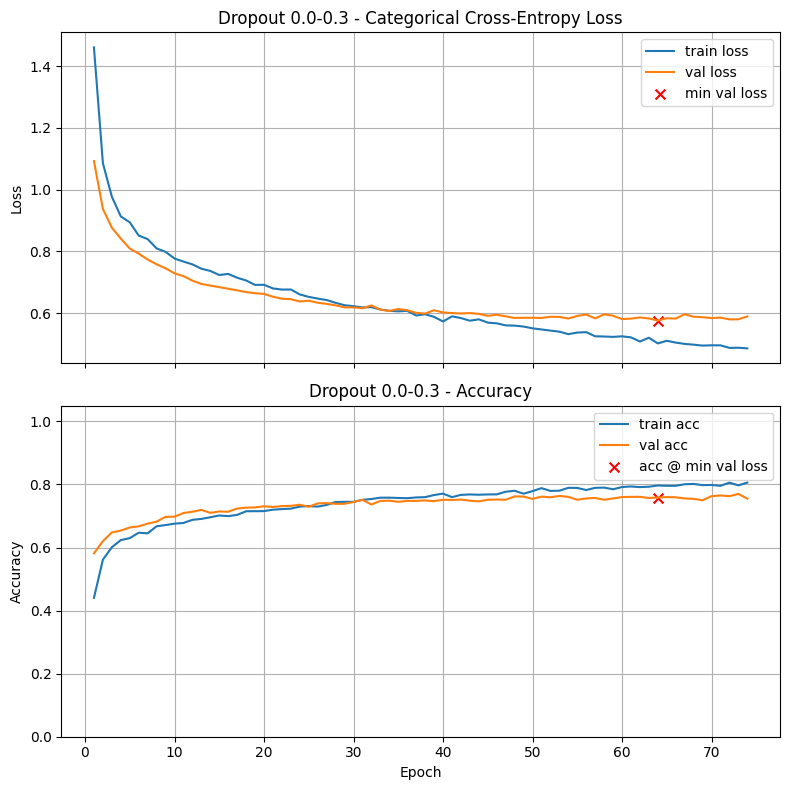

Final Training Loss:            0.4860
Final Training Accuracy:        0.8060
Final Validation Loss:          0.5895
Final Validation Accuracy:      0.7550
Minimum Validation Loss:        0.5761 (Epoch 64)
Validation Accuracy @ Min Loss: 0.7586

Test Loss: 0.5936
Test Accuracy: 0.7593

Validation-Test Gap (accuracy): 0.000714

Execution Time: 00:00:39
Best val acc = 0.7586 at epoch 63

=== Dropout: layer1=0.0, layer2=0.4 ===

Dropout 0.0-0.4



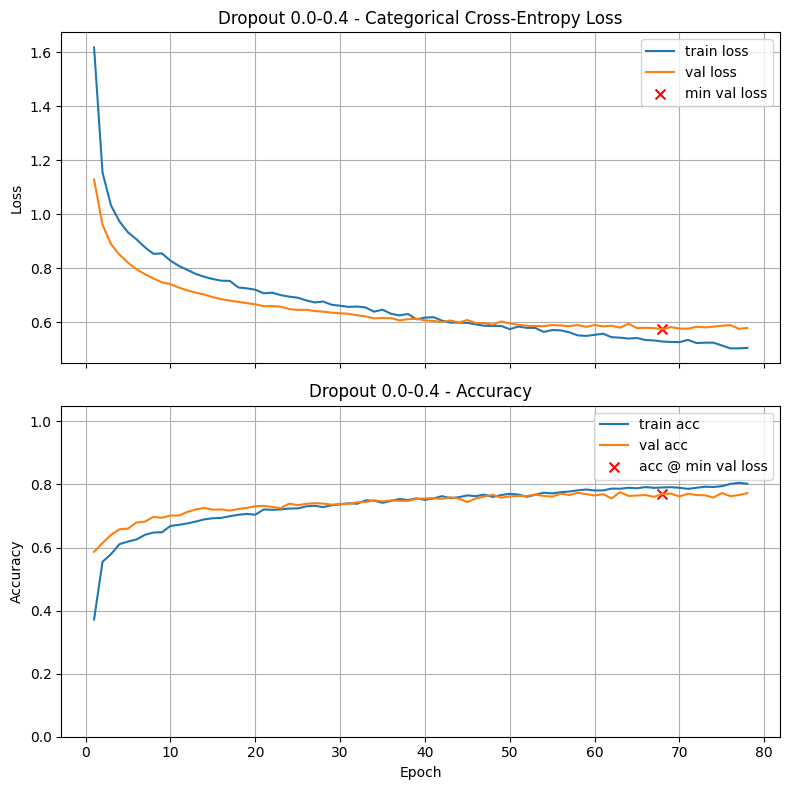

Final Training Loss:            0.5054
Final Training Accuracy:        0.8024
Final Validation Loss:          0.5792
Final Validation Accuracy:      0.7729
Minimum Validation Loss:        0.5744 (Epoch 68)
Validation Accuracy @ Min Loss: 0.7700

Test Loss: 0.6075
Test Accuracy: 0.7543

Validation-Test Gap (accuracy): 0.015714

Execution Time: 00:00:32
Best val acc = 0.7700 at epoch 67

=== Dropout: layer1=0.0, layer2=0.5 ===

Dropout 0.0-0.5



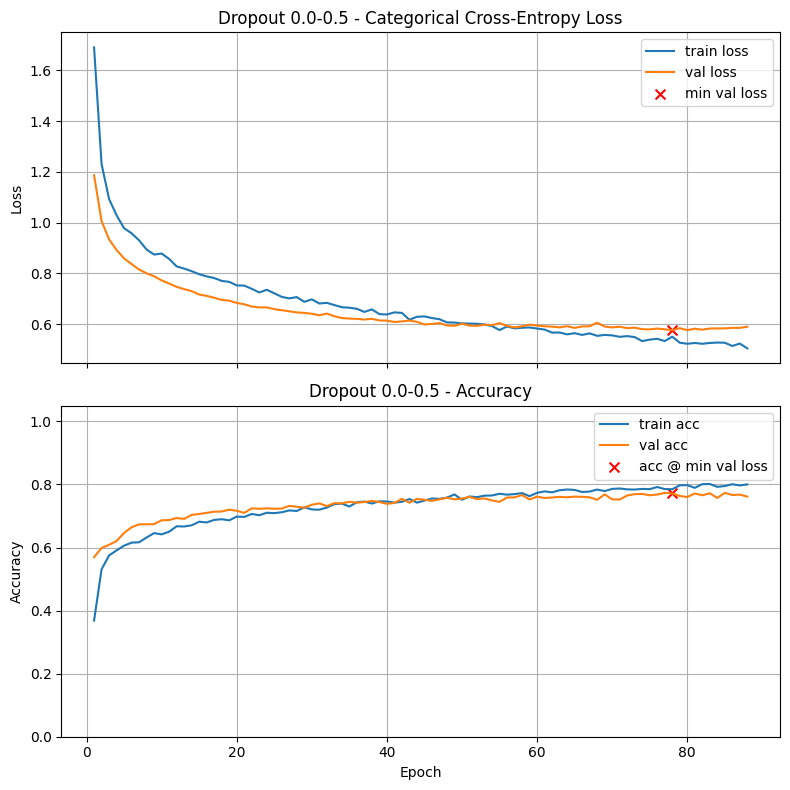

Final Training Loss:            0.5047
Final Training Accuracy:        0.8002
Final Validation Loss:          0.5903
Final Validation Accuracy:      0.7614
Minimum Validation Loss:        0.5763 (Epoch 78)
Validation Accuracy @ Min Loss: 0.7714

Test Loss: 0.6038
Test Accuracy: 0.7657

Validation-Test Gap (accuracy): 0.005714

Execution Time: 00:00:28
Best val acc = 0.7714 at epoch 77

=== Dropout: layer1=0.1, layer2=0.3 ===

Dropout 0.1-0.3



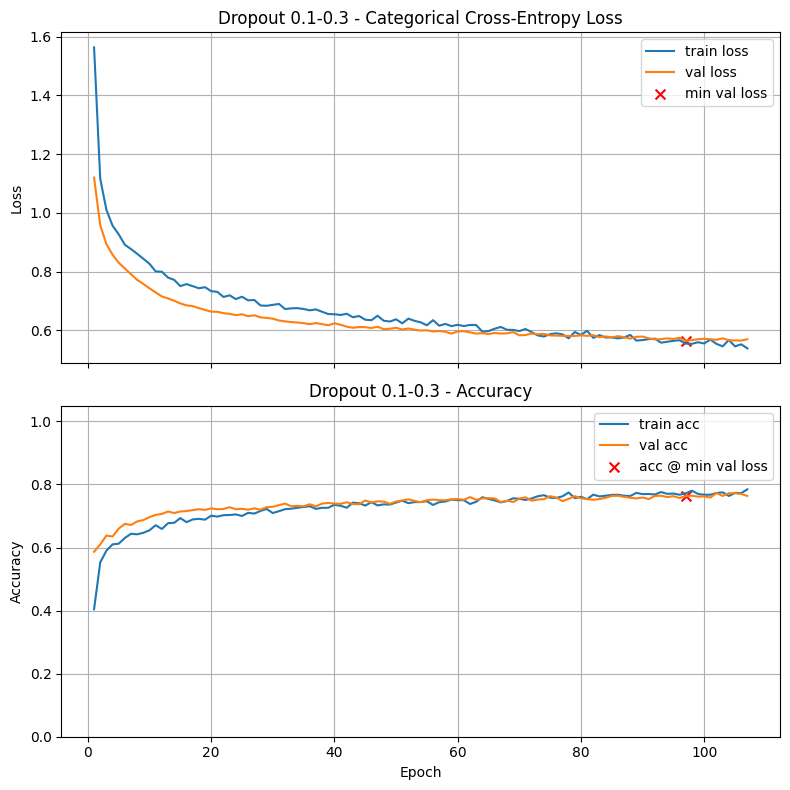

Final Training Loss:            0.5386
Final Training Accuracy:        0.7845
Final Validation Loss:          0.5695
Final Validation Accuracy:      0.7636
Minimum Validation Loss:        0.5641 (Epoch 97)
Validation Accuracy @ Min Loss: 0.7629

Test Loss: 0.5993
Test Accuracy: 0.7536

Validation-Test Gap (accuracy): 0.009286

Execution Time: 00:00:35
Best val acc = 0.7629 at epoch 96

=== Dropout: layer1=0.1, layer2=0.4 ===

Dropout 0.1-0.4



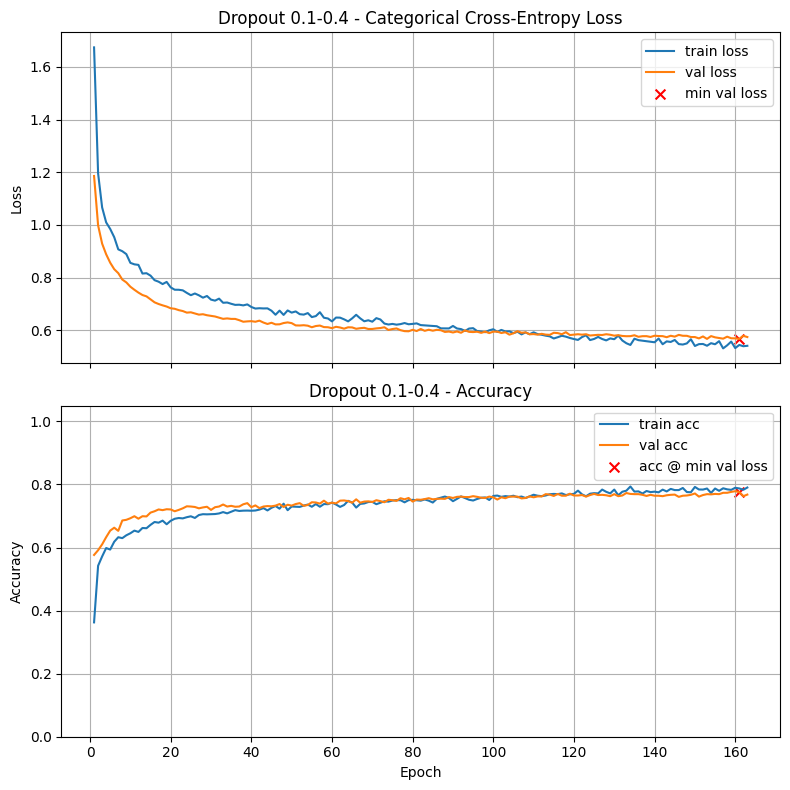

Final Training Loss:            0.5405
Final Training Accuracy:        0.7902
Final Validation Loss:          0.5739
Final Validation Accuracy:      0.7679
Minimum Validation Loss:        0.5667 (Epoch 161)
Validation Accuracy @ Min Loss: 0.7757

Test Loss: 0.5898
Test Accuracy: 0.7650

Validation-Test Gap (accuracy): 0.004286

Execution Time: 00:00:51
Best val acc = 0.7757 at epoch 160

=== Dropout: layer1=0.1, layer2=0.5 ===

Dropout 0.1-0.5



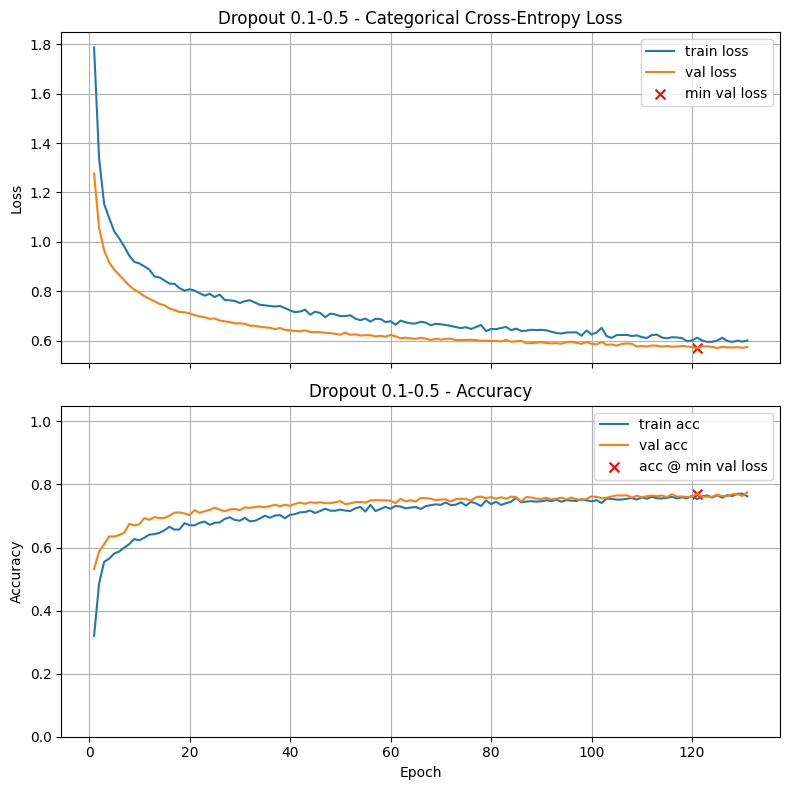

Final Training Loss:            0.6010
Final Training Accuracy:        0.7626
Final Validation Loss:          0.5743
Final Validation Accuracy:      0.7750
Minimum Validation Loss:        0.5690 (Epoch 121)
Validation Accuracy @ Min Loss: 0.7700

Test Loss: 0.6129
Test Accuracy: 0.7586

Validation-Test Gap (accuracy): 0.011429

Execution Time: 00:00:42
Best val acc = 0.7700 at epoch 120

=== Dropout: layer1=0.2, layer2=0.3 ===

Dropout 0.2-0.3



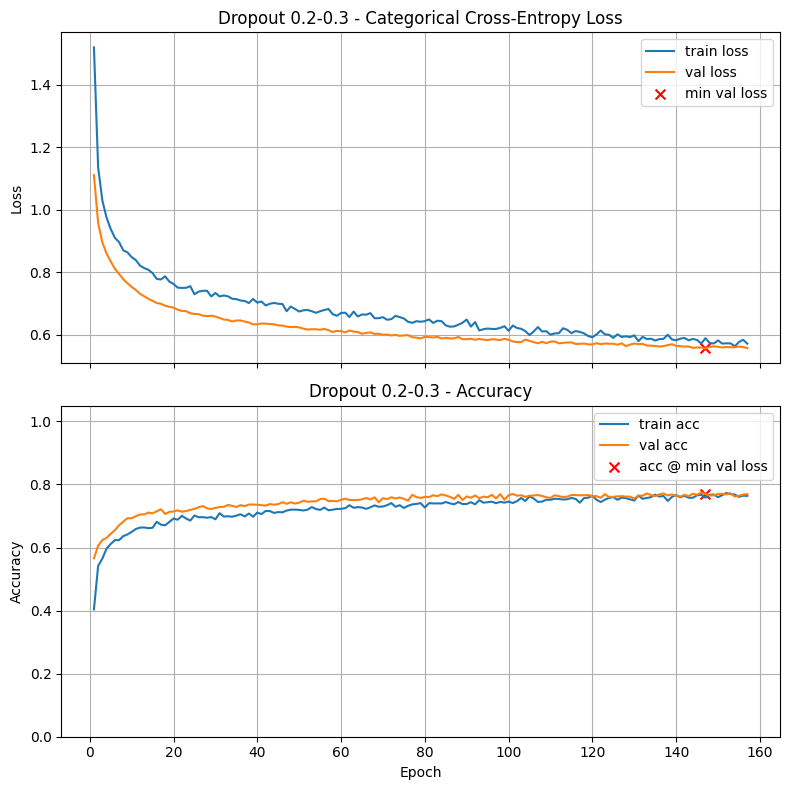

Final Training Loss:            0.5707
Final Training Accuracy:        0.7638
Final Validation Loss:          0.5568
Final Validation Accuracy:      0.7693
Minimum Validation Loss:        0.5556 (Epoch 147)
Validation Accuracy @ Min Loss: 0.7693

Test Loss: 0.5946
Test Accuracy: 0.7571

Validation-Test Gap (accuracy): 0.012143

Execution Time: 00:00:49
Best val acc = 0.7693 at epoch 146

=== Dropout: layer1=0.2, layer2=0.4 ===

Dropout 0.2-0.4



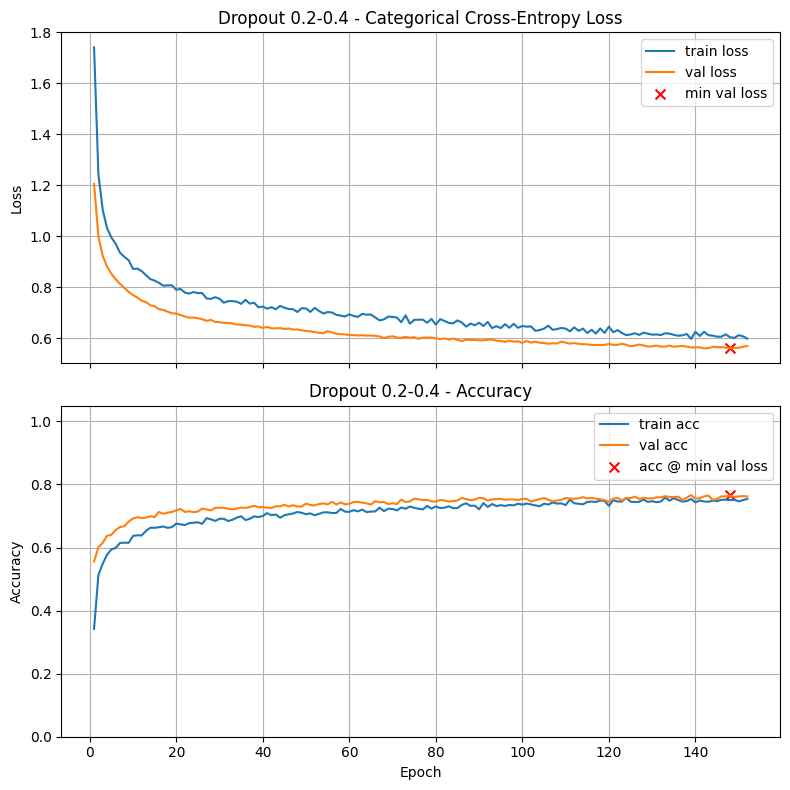

Final Training Loss:            0.5995
Final Training Accuracy:        0.7543
Final Validation Loss:          0.5708
Final Validation Accuracy:      0.7621
Minimum Validation Loss:        0.5611 (Epoch 148)
Validation Accuracy @ Min Loss: 0.7650

Test Loss: 0.5962
Test Accuracy: 0.7564

Validation-Test Gap (accuracy): 0.005714

Execution Time: 00:00:47
Best val acc = 0.7650 at epoch 147

=== Dropout: layer1=0.2, layer2=0.5 ===

Dropout 0.2-0.5



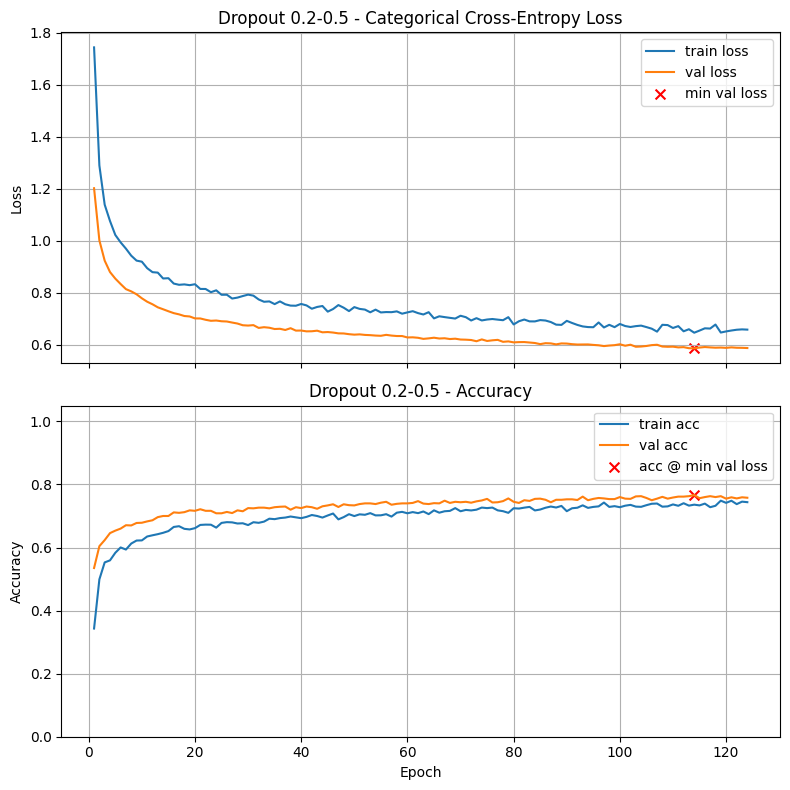

Final Training Loss:            0.6582
Final Training Accuracy:        0.7438
Final Validation Loss:          0.5874
Final Validation Accuracy:      0.7579
Minimum Validation Loss:        0.5860 (Epoch 114)
Validation Accuracy @ Min Loss: 0.7664

Test Loss: 0.6303
Test Accuracy: 0.7429

Validation-Test Gap (accuracy): 0.023571

Execution Time: 00:00:39
Best val acc = 0.7664 at epoch 113


In [29]:
# Your code here. Add as many cells as you need.
dropout_64_options = [0.0, 0.1, 0.2]
dropout_32_options = [0.3, 0.4, 0.5]

results_dropout = {}

best_act = 'tanh'
best_lr  = a2a

for d64 in dropout_64_options:
    for d32 in dropout_32_options:
        print(f"\n=== Dropout: layer1={d64}, layer2={d32} ===")

        layer_list = [
            (64, best_act, 0.0, d64),
            (32, best_act, 0.0, d32)
        ]

        model_baseline = build_model(n_inputs=X_train.shape[1], layer_list=layer_list, n_classes=len(np.unique(y_train)))

        history = train_and_test(model_baseline,
                                 epochs=500,
                                 lr_schedule=best_lr,
                                 batch_size=64,
                                 title=f"Dropout {d64}-{d32}",
                                 verbose=0,
                                 return_history=True)

        min_val_loss_epoch = np.argmin(history.history['val_loss'])
        best_val_acc = history.history['val_accuracy'][min_val_loss_epoch]

        results_dropout[(d64, d32)] = (best_val_acc, min_val_loss_epoch)
        print(f"Best val acc = {best_val_acc:.4f} at epoch {min_val_loss_epoch}")



In [30]:
results_dropout

{(0.0, 0.3): (0.758571445941925, np.int64(63)),
 (0.0, 0.4): (0.7699999809265137, np.int64(67)),
 (0.0, 0.5): (0.7714285850524902, np.int64(77)),
 (0.1, 0.3): (0.7628571391105652, np.int64(96)),
 (0.1, 0.4): (0.7757142782211304, np.int64(160)),
 (0.1, 0.5): (0.7699999809265137, np.int64(120)),
 (0.2, 0.3): (0.7692857384681702, np.int64(146)),
 (0.2, 0.4): (0.7649999856948853, np.int64(147)),
 (0.2, 0.5): (0.7664285898208618, np.int64(113))}

In [31]:
sorted_results_dropout = dict(sorted(results_dropout.items(), key=lambda dropout: dropout[1], reverse=True))
sorted_results_dropout

{(0.1, 0.4): (0.7757142782211304, np.int64(160)),
 (0.0, 0.5): (0.7714285850524902, np.int64(77)),
 (0.1, 0.5): (0.7699999809265137, np.int64(120)),
 (0.0, 0.4): (0.7699999809265137, np.int64(67)),
 (0.2, 0.3): (0.7692857384681702, np.int64(146)),
 (0.2, 0.5): (0.7664285898208618, np.int64(113)),
 (0.2, 0.4): (0.7649999856948853, np.int64(147)),
 (0.1, 0.3): (0.7628571391105652, np.int64(96)),
 (0.0, 0.3): (0.758571445941925, np.int64(63))}

In [32]:
results_dropout_list = list(sorted_results_dropout.keys())
results_dropout_list

[(0.1, 0.4),
 (0.0, 0.5),
 (0.1, 0.5),
 (0.0, 0.4),
 (0.2, 0.3),
 (0.2, 0.5),
 (0.2, 0.4),
 (0.1, 0.3),
 (0.0, 0.3)]

In [33]:
# Set a3a to the pair (dropout_rate_64,dropout_rate_32) of dropout rates for the two hidden layers which provided the best
# validation accuracy at the epoch of minimum validation loss

a3a = results_dropout_list[0]             # Replace (0.0,0.0) with your answer

In [34]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3a = {a3a}')

a3a = (0.1, 0.4)


In [35]:
# Set a3b to the validation accuracy found by this best pair of dropout rates

a3b = sorted_results_dropout[a3a][0]             # Replace 0.0 with your answer

In [36]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3b = {a3b:.4f}')

a3b = 0.7757


### Problem Four: L2 Regularization

In this problem, you will explore how **L2 regularization** (also called *weight decay*) can help prevent overfitting in neural networks. There are no absolute rules, but some useful heuristics are:

* Start simple by using the **same λ in both hidden layers**, with values:

  ```
      1e-4, 1e-3, 1e-2
  ```

* If validation results suggest underfitting in the first layer or persistent overfitting in the later one, then try adjusting per layer, for example:

  * First hidden layer: λ = 1e-4
  * Second hidden layer: λ = 1e-3

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**, but **without dropout**.
* Investigate at least the four cases suggested (three with the same λ and one with different λ values). You may also consider additional combinations.
* Identify which configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.


In [ ]:
# Your code here. Add as many cells as you need.
lambda_configs = [
    (1e-4, 1e-4),
    (1e-3, 1e-3),
    (1e-2, 1e-2),
    (1e-4, 1e-3),
    (1e-3, 1e-4)  # optional
]

results_l2 = {}

best_act = 'tanh'
best_lr  = a2a

for l1, l2 in lambda_configs:
    print(f"\n=== Testing L2: λ1={l1}, λ2={l2} ===")

    layer_list = [
        (64, best_act, l1, 0.0),   # dropout = 0.0
        (32, best_act, l2, 0.0)
    ]

    model_baseline = build_model(n_inputs=X_train.shape[1], layer_list=layer_list, n_classes=len(np.unique(y_train)))

    history = train_and_test(model_baseline,
                             epochs=500,
                             lr_schedule=best_lr,
                             batch_size=64,
                             title=f"L2 λ1={l1}, λ2={l2}",
                             verbose=0,
                             return_history=True)

    min_val_loss_epoch = np.argmin(history.history['val_loss'])
    best_val_acc = history.history['val_accuracy'][min_val_loss_epoch]

    results_l2[(l1, l2)] = (best_val_acc, min_val_loss_epoch)
    print(f"Best val acc = {best_val_acc:.4f} at epoch {min_val_loss_epoch}")



In [ ]:
results_l2

In [ ]:
sorted_results_l2 = dict(sorted(results_l2.items(), key=lambda l2: l2[1], reverse=True))
sorted_results_l2

In [ ]:
print_results()

In [ ]:
# Set a4a to the pair (L2_lambda_64,L2_lambda_32) of the L2 lambdas for the two hidden layers which provided the best
# validation accuracy at the epoch of minimum validation loss

a4a = (0.0,0.0)             # Replace (0.0,0.0) with your answer

In [ ]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a4a = {a4a}')

a4a = (0.0, 0.0)


In [ ]:
# Set a4b to the validation accuracy found by this best pair of lambdas

a4b = 0.0             # Replace 0.0 with your answer

In [ ]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a4b = {a4b:.4f}')

a4b = 0.0000


### Problem Five: Combining Dropout with L2 Regularization

In this problem, you will explore how **dropout** and **L2 regularization** can work together to prevent overfitting. These two methods complement each other, but must be balanced carefully. A useful rule of thumb is:

* If dropout is **high**, use a **smaller λ**.
* If dropout is **low**, you can afford a **larger λ**.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate combinations of dropout and L2:

  * First, use the **dropout rate you identified in Problem Three** as a baseline.
  * Then, add L2 to both hidden layers with values:

    ```
        1e-4, 1e-3, 1e-2
    ```

    while keeping dropout fixed.
  * Finally, try **reducing dropout slightly** when L2 is added to see if performance improves.
  * [Optional] You may wish to investigate other combinations not covered here; for example, promising but not optimal choices of dropout rates may provide overall better performance when combines with L2 Regulari
* Identify which combination produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



In [ ]:
# Your code here. Add as many cells as you need.
dropout_configs = [
    (0.1, 0.4),   # best from a3a
    (0.1, 0.3),
    (0.05, 0.3),
    (0.0, 0.3)
]

lambda_values = [1e-4, 1e-3, 1e-2]

best_act = 'tanh'
best_lr  = a2a

results_combo = {}

for d64, d32 in dropout_configs:
    for lam in lambda_values:
        print(f"\n=== Dropout ({d64}, {d32}) + L2 λ={lam} ===")

        layer_list = [
            (64, best_act, lam, d64),
            (32, best_act, lam, d32)
        ]

        model_baseline = build_model(n_inputs=X_train.shape[1], layer_list=layer_list, n_classes=len(np.unique(y_train)))

        history = train_and_test(model_baseline,
                                 epochs=500,
                                 lr_schedule=best_lr,
                                 batch_size=64,
                                 title=f"D({d64},{d32}) + L2={lam}",
                                 verbose=0,
                                 return_history=True)

        min_val_loss_epoch = np.argmin(history.history['val_loss'])
        best_val_acc = history.history['val_accuracy'][min_val_loss_epoch]

        results_combo[(d64, d32, lam)] = (best_val_acc, min_val_loss_epoch)
        print(f"Val acc = {best_val_acc:.4f} at epoch {min_val_loss_epoch}")


In [ ]:
# Set a5 to the validation accuracy found by this best combination of dropout and L2 regularization

a5 = 0.0             # Replace 0.0 with your answer

In [ ]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a5 = {a5:.4f}')

a5 = 0.0000


### Problem Six: Build and Train Your Best Model

In this final problem, you will design and train your **best-performing model** using the techniques explored in the previous problems. You may make your own choices for:

* **Model architecture** (number of layers, widths, etc.)
* **Learning rate**
* **Batch size** (a new hyperparameter not varied in earlier problems)
* **Dropout rates** in both layers
* **L2 λ values** in both layers
* **[Optional but strongly suggested]:** Learning rate scheduling, using either **Exponential Decay** or **Cosine Decay**.

  * For Exponential Decay, typical decay rates are **0.90–0.999**, with **0.95** often a good starting point.

**Steps to follow:**

* Build and train the model according to your design choices.
* Use early stopping as before to evaluate performance at the epoch of **minimum validation loss**.
* Answer the graded question.


In [ ]:
# Your code here


In [ ]:
# Set a6 to the validation accuracy found by this best model

a6 = 0.0             # Replace 0.0 with your answer

In [ ]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a6 = {a6:.4f}')

a6 = 0.0000


### Optional: Print out your results of all experiments

In [ ]:
print_results()

## Reflection Questions (ungraded)

It would be a great idea to think through your answers to these questions, then give ChatGPT (or other AI tool) a PDF of your
homework, and **discuss** (not just ask) these.

1. Activation Functions:

    - Why do you think one activation function worked better than the others for this task?
    
    - How might this choice differ for deeper or wider networks?

2. Learning Rate:

    - Would a much smaller learning rate (with many more epochs) likely produce better accuracy?
    
    - When is it worth training longer with a smaller step size, and when is it unnecessary?

3. Dropout vs. L2:

    - Which form of regularization — dropout or L2 — gave better results in your experiments?
    
    - Why might one method be more effective in this setting?

4. Combining Dropout and L2:

    - Why might the combination of dropout and L2 sometimes perform worse than using one method alone?
    
    - What does this tell you about the balance between bias and variance in regularization?

5. Best Model:

    - When you designed your best model, what trade-offs did you notice between model complexity, training stability, and generalization?
    
    - Did learning rate scheduling (if you tried it) improve results? Why might it help?